# Visualisation des données de couverture nuageuse MODIS
#### Couverture nuageuse de chaque étage, Evolution temporelle, cartes spatiales, coupes verticales


In [1]:
import os

import netCDF4 as nc

import math
import numpy as np
import numpy.ma as ma

import matplotlib.pyplot as plt
from matplotlib import cm

import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from myfunctions import *

from scipy import interpolate
from scipy.interpolate import griddata

In [2]:
######### EXTRACTION DES DONNEES DE COUVERTURE NUAGEUSE MODIS ##########

# Where to save images
rep0 = './quicklooks/'
# If the directory does not exist, we create it
if not(os.path.exists(rep0)):
    os.makedirs(rep0)

# Projection for plotting
proj = ccrs.LambertConformal(central_latitude = 37,
                             central_longitude = 10,
                             standard_parallels = (37, 37)
                             )

var1 = 'Cloud_Fraction_Mask_Low_Mean'
var2 = 'Cloud_Fraction_Mask_Mid_Mean'
var3 = 'Cloud_Fraction_Mask_High_Mean'
var4 = 'Cloud_Fraction_Mask_Total_Mean'
var5 = 'Cloud_Optical_Thickness_Total_Mean'
var6 = 'Cloud_Top_Pressure_Total_Mean'

data4d = np.zeros((96,180,360,6))
i=0
for annee in range (2007,2015):
    for mois in range (1,13):
        if mois<10:
            fin = 'MODIS/MCD08_M3_NC.'+str(annee)+".0"+str(mois)+'.C051.V02.nc'
        else :
            fin = 'MODIS/MCD08_M3_NC.'+str(annee)+"."+str(mois)+'.C051.V02.nc'
        d = nc.Dataset(fin)
        
        data1 = d[var1][:,:]
        data2 = d[var2][:,:]
        data3 = d[var3][:,:]
        data4 = d[var4][:,:]
        data5 = d[var5][:,:]
        data6 = d[var6][:,:]
        data4d[i,:,:,0] = data1[:,:]
        data4d[i,:,:,1] = data2[:,:]
        data4d[i,:,:,2] = data3[:,:]
        data4d[i,:,:,3] = data4[:,:]
        data4d[i,:,:,4] = data5[:,:]
        data4d[i,:,:,5] = data6[:,:]
        i=i+1

lat = d['lat'][:]
lon = d['lon'][:]
Lon,Lat = np.meshgrid(lon,lat)

d.close()

print(data1.shape)
print(Lon)
##### -- to nan #####

data_filtre = np.zeros((96,180,360,6))
data_filtre[:] = np.nan

for k in range(96):
    for i in range(101):
        for j in range(153):
            for l in range(4):
                if data4d[k,i,j,l]>=0 and data4d[k,i,j,l]<=1:
                    data_filtre[k,i,j,l] = data4d[k,i,j,l]
                else:
                    data_filtre[k,i,j,l] = np.nan
data_filtre[:,:,:,4] = data4d[:,:,:,4]
data_filtre[:,:,:,5] = data4d[:,:,:,5]
                
##### Supprime les mauvaises annees ######
'''
data_filtre2 = np.zeros((120,101,153,4))
data_filtre2[:] = np.nan
for i in range(48):
	data_filtre2[i,:,:,:] = data_filtre[i,:,:,:]
for i in range(49,52):
	data_filtre2[i,:,:,:] = data_filtre[i,:,:,:]
for i in range(65,120):
	data_filtre2[i,:,:,:] = data_filtre[i,:,:,:]
'''

(180, 360)
[[-179.5 -178.5 -177.5 ...  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...  177.5  178.5  179.5]
 ...
 [-179.5 -178.5 -177.5 ...  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...  177.5  178.5  179.5]
 [-179.5 -178.5 -177.5 ...  177.5  178.5  179.5]]


'\ndata_filtre2 = np.zeros((120,101,153,4))\ndata_filtre2[:] = np.nan\nfor i in range(48):\n\tdata_filtre2[i,:,:,:] = data_filtre[i,:,:,:]\nfor i in range(49,52):\n\tdata_filtre2[i,:,:,:] = data_filtre[i,:,:,:]\nfor i in range(65,120):\n\tdata_filtre2[i,:,:,:] = data_filtre[i,:,:,:]\n'

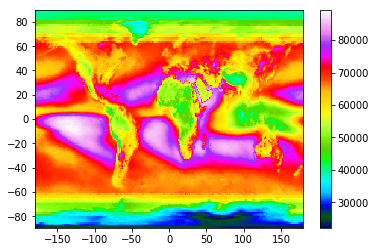

In [10]:
plt.pcolormesh(Lon,Lat,np.nanmean(data4d[:,:,:,5],axis=0),cmap=cm.gist_ncar)
plt.colorbar()

In [3]:
##### RE INTERPOLATION SUR LA GRILLE ALADIN ######

# grille ALADIN

fin = 'rsut_CERES_EBAF_Ed4-1_200003-201901_regrid_ALADIN_bilinear.nc'
d = nc.Dataset(fin)
lat_A = d['lat'][:]
lon_A = d['lon'][:]
d.close()

# Suppression des valeurs aberrantes et des trous, méthode linéaire

data_inter = np.zeros((96,101,153,6))
data_inter[:] = np.nan

for i in range(96):
    for j in range(6):
        xx = Lon[np.isfinite(data4d[i,:,:,j])].ravel()
        yy = Lat[np.isfinite(data4d[i,:,:,j])].ravel()
        dd = data4d[i,:,:,j][np.isfinite(data4d[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat_A, lon_A), method='linear')
'''
for i in range(48):
    for j in range(4):
        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()
        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()
        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')
        
for i in range(49,52):
    for j in range(4):
        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()
        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()
        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')
        
for i in range(65,120):
    for j in range(4):
        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()
        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()
        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()
        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')
'''

"\nfor i in range(48):\n    for j in range(4):\n        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()\n        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()\n        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()\n        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')\n        \nfor i in range(49,52):\n    for j in range(4):\n        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()\n        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()\n        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()\n        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='linear')\n        \nfor i in range(65,120):\n    for j in range(4):\n        xx = lon[np.isfinite(data_filtre[i,:,:,j])].ravel()\n        yy = lat[np.isfinite(data_filtre[i,:,:,j])].ravel()\n        dd = data_filtre[i,:,:,j][np.isfinite(data_filtre[i,:,:,j])].ravel()\n        data_inter[i,:,:,j] = griddata((yy, xx),dd,(lat, lon), method='li

In [4]:
####### MOYENNE CLIMATO 2007-016 #########

# Temporal mean - season

data_season = np.zeros((4,8,101,153,6))
data_season[:] = np.nan

for i in range(8):
    if i==0:
        data_season[0,i,:,:,:] = np.nanmean(data_inter[(0+12*i):(2+12*i),:,:,:],axis=0)
    else:
        data_season[0,i,:,:] = np.nanmean(data_inter[(-1+12*i):(2+12*i),:,:,:],axis=0)
    data_season[1,i,:,:,:] = np.nanmean(data_inter[(2+12*i):(5+12*i),:,:,:],axis=0)
    data_season[2,i,:,:,:] = np.nanmean(data_inter[(5+12*i):(8+12*i),:,:,:],axis=0)
    data_season[3,i,:,:,:] = np.nanmean(data_inter[(8+12*i):(11+12*i),:,:,:],axis=0)

data_season_moy = np.nanmean(data_season,axis=1)

# Temporal mean _ anual

data_moy_inter = np.nanmean(data_inter,axis=0)

# Temporal_mean - month

data_month = np.zeros((12,8,101,153,6))
data_month[:] = np.nan

for i in range(8):
    for j in range(12):
        for k in range(6):
            data_month[j,i,:,:,k] = data_inter[(j+12*i),:,:,k]
        
data_month_moy = np.nanmean(data_month,axis=1)


##### determination de boites #####

nt,nlat,nlon = (1,101,153)

    
lat_min = 45
lat_max = 55
lon_min = -30
lon_max = -21

# find coords of nearest point in grid from point (TARGET_LAT, TARGET_LON)
    
target_x = []
target_y = []
 
for x in range(nlon):
    for y in range(nlat):
        if lat_A[y,x]>=lat_min and lat_A[y,x]<=lat_max and lon_A[y,x]>=lon_min and lon_A[y,x]<=lon_max:
            target_x.append(x)
            target_y.append(y)
                 

# Temporal mean - box

data_boite=np.zeros((12,len(target_x),4))
data_boite_moy=np.zeros((12,len(target_x),4))
  
for j in range(12):
    for k in range(len(target_x)):
        data_boite[j,k,:] =  data_month_moy[j,target_y[k],target_x[k],0:4] 

data_boite_moy = np.nanmean(data_boite,axis=1)

print(target_x)



[15, 15, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,

Text(0.5,1,'Cloud Fraction (%) in North Atlantic (-30W,45N / -21,55N) - MODIS 2007 to 2014')

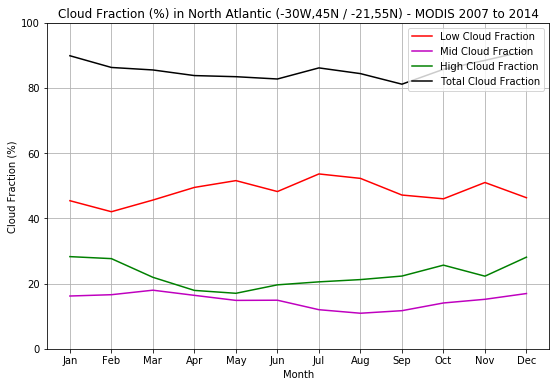

In [17]:
########## PLOT ###########

#North Atlantic (-30W,45N / -21,55N)
#Eastern europe (20E,50N / 30E,55N)
#Western Mediterranean (3E,37N / 8.5E,42.5N)
#Eastern Mediterranean (15E,33N / 22E,37N)
#Western Sahara (-6W,20N / 4E,27N)
#Eastern Sahara (24E,19N / 30E,25N)


months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig=plt.figure(figsize=(9,6))
plt.plot(months,data_boite_moy[:,0]*100,label='Low Cloud Fraction',color='r')
plt.plot(months,data_boite_moy[:,1]*100,label='Mid Cloud Fraction',color='m')
plt.plot(months,data_boite_moy[:,2]*100,label='High Cloud Fraction',color='g')
plt.plot(months,data_boite_moy[:,3]*100,label='Total Cloud Fraction',color='k')
plt.legend()
plt.ylim(0,100)
plt.grid()
plt.xlabel('Month')
plt.ylabel('Cloud Fraction (%)')
plt.title('Cloud Fraction (%) in North Atlantic (-30W,45N / -21,55N) - MODIS 2007 to 2014')

Text(0.5,1,'Meridian vertical section - Cloud fraction (%) - Eastern Europe and Sahara - 2007 to 2014')

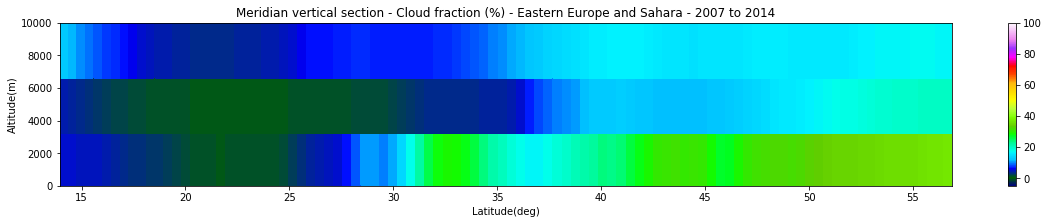

In [47]:
########## COUPES VERTICALES ##########

lat_coupe = 85
lon_coupe = 110

z = np.array([0,3200,6600,10000])
lat_liste=lat_A[:,lon_coupe]
lon_liste=lon_A[lat_coupe,:]
z_lat,lat_z = np.meshgrid(z,lat_liste)
z_lon,lon_z = np.meshgrid(z,lon_liste)

data_moy_inter2 = data_moy_inter
data_moy_inter2[:,:,3] = np.copy(data_moy_inter2[:,:,2])


fig=plt.figure(figsize=(20,3))

#plt.contourf(lat_z[:,0:4],z_lat[:,0:4],data_moy_inter[:,lat_coupe,0:4]*100,vmin=0,vmax=100,\
#             levels=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],cmap=cm.gist_ncar)

plt.pcolormesh(lat_z[:,0:4],z_lat[:,0:4],data_moy_inter2[:,lon_coupe,0:4]*100,vmin=-5,vmax=100,cmap=cm.gist_ncar)
plt.xlabel('Latitude(deg)')
plt.ylabel('Altitude(m)')
plt.colorbar()
plt.title('Meridian vertical section - Cloud fraction (%) - Eastern Europe and Sahara - 2007 to 2014')


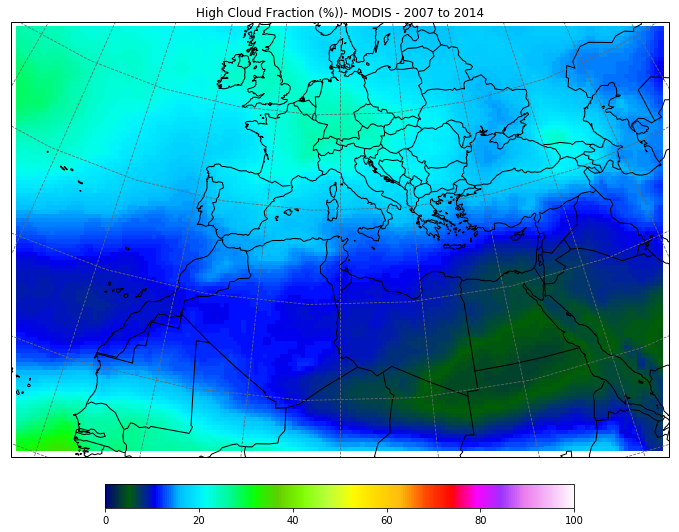

In [7]:
######### PLOTS SUR LA PERIODE COMPLETE ##########

# Domain to be plotted
bbox = [-24,44,14,56]

# Map projection is Lambert Conformal (proj)
fig, ax = plt.subplots(figsize=(12,10),subplot_kw=dict(projection=proj))

# Apply domain to be plotted
ax.set_extent(bbox,crs=ccrs.PlateCarree())
# Add coastlines
ax.coastlines('50m')
# Add country borders
ax.add_feature(cf.BORDERS)

# *must* call draw in order to get the axis boundary used to add ticks
fig.canvas.draw()

xticks = range(-180,181,10)
yticks = range(-90,91,10)
ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')

# Label the end-points of the gridlines using the custom tick makers:
ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

#lambert_xticks(ax, xticks)
#lambert_yticks(ax, yticks)

#ax.set_title('{0} ({1}) - {2}'.format(name,units,dates[0]))
ax.set_title('High Cloud Fraction (%))- MODIS - 2007 to 2014')

# Plot data
cs = ax.pcolormesh(lon_A,lat_A,data_moy_inter[:,:,2]*100, transform=ccrs.PlateCarree(),
        cmap=cm.gist_ncar,vmin=0.,vmax=100.,shading='flat')

# Add colorbar
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal',pad=0.05)

# Save in png

a = 'DiffTot_surf'

#plt.savefig('{0}/{1}_obs.png'.format(rep0,a))
plt.show()
plt.close()


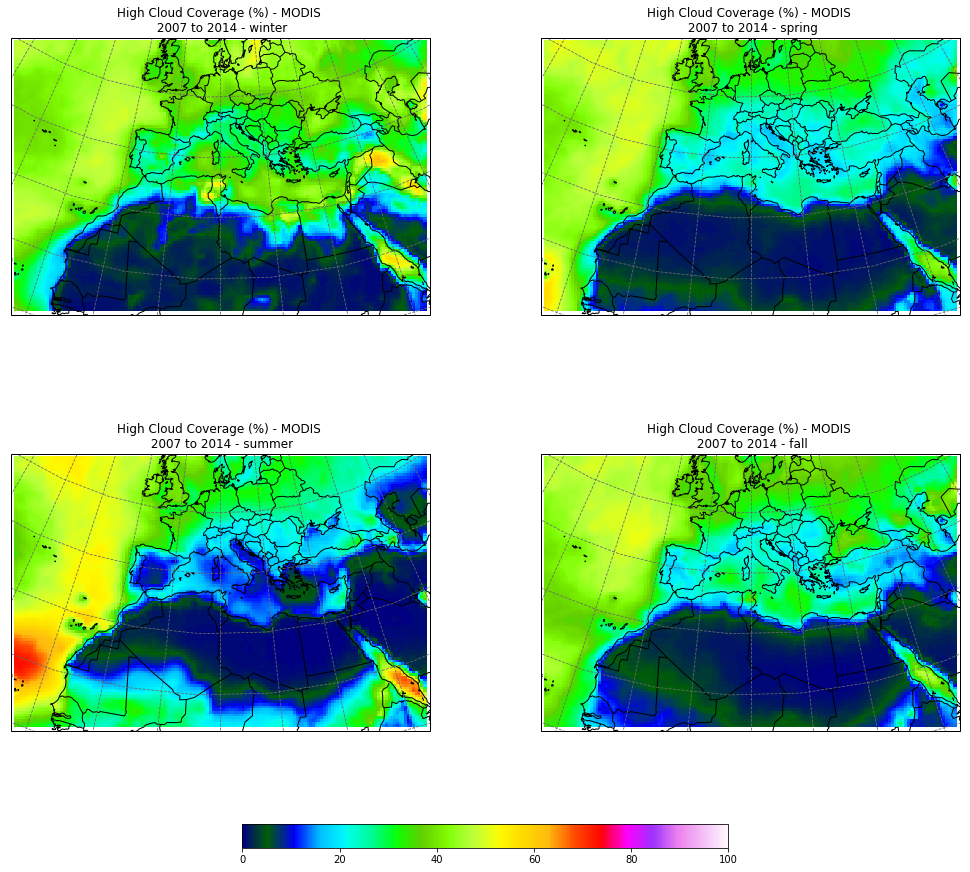

In [56]:
########## SUBPLOTS SEASONS ###########

# Domain to be plotted
bbox = [-24,44,14,56]

# Map projection is Lambert Conformal (proj)
fig, axes = plt.subplots(2,2,figsize=(20,17),subplot_kw=dict(projection=proj))
title_season = ['winter','spring','summer','fall']

for i, ax in enumerate(axes.flat):
	# Apply domain to be plotted
	ax.set_extent(bbox,crs=ccrs.PlateCarree())
		# Add coastlines
	ax.coastlines('50m')
	
		# Add country borders
	ax.add_feature(cf.BORDERS)
	
		# *must* call draw in order to get the axis boundary used to add ticks
	fig.canvas.draw()
	
	xticks = range(-180,181,10)
	yticks = range(-90,91,10)
	ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=1,color='dimgrey')
	
    	# Label the end-points of the gridlines using the custom tick makers:
	ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
	ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)
	
	#lambert_xticks(ax, xticks)
	#lambert_yticks(ax, yticks)
	
	
	ax.set_title('High Cloud Coverage (%) - MODIS \n 2007 to 2014 - {0}'.format(title_season[i]))
	
    	# Plot data
	cs = ax.pcolormesh(lon_A,lat_A,data_season_moy[i,:,:,0]*100, transform=ccrs.PlateCarree(),cmap=cm.gist_ncar, vmin=0., vmax=100.,shading='flat')

# Add colorbar
fig.subplots_adjust(right=0.8, hspace=0.5)
cbar = fig.colorbar(cs, ax=axes[:,:], shrink=0.5, orientation='horizontal',pad=0.1)

# Save in png
#plt.savefig('{0}/{1}_all_seasons_brut_3.png'.format(rep0,var))

plt.show()
plt.close()